In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from e3nn import o3
import matplotlib.pyplot as plt

from layers.preprocess import load_mol_graphs
from layers.embedding import OneHotAtomEncoding, SphericalHarmonicEdgeAttrs
from layers.dataset import GraphDataset, collate_fn
from layers.model import NequIP

In [ ]:
# Data Parameters:
LMAX = 2
RMAX = 2.0 
NUM_BASIS = 8
P = 6

BASIS_KWARGS = {'r_max': RMAX, 'num_basis': NUM_BASIS, 'trainable': True}
CUTOFF_KWARGS = {'r_max':RMAX, 'p': P}

BNI = 8    # base number of irreps
CHEMICAL_EMBEDDING_IRREPS_OUT = o3.Irreps(f"{BNI}x0e")
FEATURE_IRREPS_HIDDEN = o3.Irreps(f"{BNI}x0o + {BNI}x0e + {BNI}x1o + {BNI}x1e + {BNI}x2o + {BNI}x2e")
CONV_TO_OUTPUT_HIDDEN_IRREPS_OUT = o3.Irreps(f"{int(BNI / 2)}x0e")

NONLINEARITY_SCALARS = {'e': 'silu', 'o': 'tanh'}
NONLINEARITY_GATES = {'e': 'silu', 'o': 'tanh'}

INVARIANT_LAYERS = 2
INVARIANT_NEURONS = 32

NUM_CONV_LAYERS = 4
RESNET = False
USE_SC = True
PEP_ATOM_OUT_FIELD = 'per_atom_pred'
PRED_OUT_FIELD = 'auc_pred'

config = {'basis_kwargs': BASIS_KWARGS,
          'cutoff_kwargs': CUTOFF_KWARGS,
          'chemical_embedding_irreps_out': CHEMICAL_EMBEDDING_IRREPS_OUT,
          'num_conv_layers': NUM_CONV_LAYERS,
          'feature_irreps_hidden': FEATURE_IRREPS_HIDDEN,
          'resnet': RESNET,
          'nonlinearity_scalars': NONLINEARITY_SCALARS,
          'nonlinearity_gates': NONLINEARITY_GATES,
          'num_basis': NUM_BASIS,
          'invariant_layers': INVARIANT_LAYERS,
          'invariant_neurons': INVARIANT_NEURONS,
          'use_sc': USE_SC,
          'conv_to_output_hidden_irreps_out': CONV_TO_OUTPUT_HIDDEN_IRREPS_OUT,
          'per_atom_out_field': PEP_ATOM_OUT_FIELD,
          'pred_out_field': PRED_OUT_FIELD}


# Training Parameters:
BATCH_SIZE = 5
TEST_SIZE = 0.20
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

In [37]:
path_to_ligands = 'data/ligands'
path_to_auc = 'data/auc_scores.csv'
mol_dataset, num_atom_types = load_mol_graphs(path_to_ligands, path_to_auc)

for mol_dict in mol_dataset:
    mol_dict = OneHotAtomEncoding(num_types=num_atom_types)(mol_dict)
    mol_dict = SphericalHarmonicEdgeAttrs(l_max=LMAX)(mol_dict)

In [ ]:
train_data, test_data = train_test_split(mol_dataset, test_size=TEST_SIZE)
train_dataset, test_dataset = GraphDataset(train_data), GraphDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NequIP(**config, batch=next(iter(train_loader)))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-7)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.7)
loss_fn = torch.nn.MSELoss()

In [40]:
train_losses, test_losses = [], []

for epoch in range(NUM_EPOCHS):
    epoch_train_loss, epoch_test_loss = 0.0, 0.0

    model.train()
    for batch in train_loader:
        for key in batch:
            batch[key] = batch[key].to(device) if isinstance(batch[key], torch.Tensor) else batch[key]

        optimizer.zero_grad()
        batch = model(batch)
        loss = loss_fn(batch['auc_pred'], batch['auc'])
        loss.backward()
        optimizer.step()       

        epoch_train_loss += loss.item() * len(batch['num_nodes'])

    model.eval()
    for batch in test_loader:
        for key in batch:
            batch[key] = batch[key].to(device) if isinstance(batch[key], torch.Tensor) else batch[key]

        batch = model(batch)
        loss = loss_fn(batch['auc_pred'], batch['auc'])
        
        epoch_test_loss += loss.item() * len(batch['num_nodes'])

    scheduler.step()

    train_losses.append(epoch_train_loss / len(train_loader.dataset))
    test_losses.append(epoch_test_loss / len(test_loader.dataset))

    print(f'Epoch {epoch} | Train Loss: {train_losses[-1]:.4f} | Test Loss: {test_losses[-1]:.4f}')

Epoch 0 | Train Loss: 8.4400 | Test Loss: 8.6753
Epoch 1 | Train Loss: 8.2066 | Test Loss: 8.2569
Epoch 2 | Train Loss: 7.6400 | Test Loss: 7.7287
Epoch 3 | Train Loss: 7.2962 | Test Loss: 7.7666
Epoch 4 | Train Loss: 7.2326 | Test Loss: 7.7302
Epoch 5 | Train Loss: 7.2322 | Test Loss: 7.7140
Epoch 6 | Train Loss: 7.2003 | Test Loss: 7.7117
Epoch 7 | Train Loss: 7.1121 | Test Loss: 7.7462
Epoch 8 | Train Loss: 7.1446 | Test Loss: 7.7235
Epoch 9 | Train Loss: 7.0469 | Test Loss: 7.6679
Epoch 10 | Train Loss: 6.9169 | Test Loss: 7.7994
Epoch 11 | Train Loss: 6.8288 | Test Loss: 7.7033
Epoch 12 | Train Loss: 6.8292 | Test Loss: 7.6328
Epoch 13 | Train Loss: 6.6038 | Test Loss: 7.6858
Epoch 14 | Train Loss: 6.5582 | Test Loss: 7.7173
Epoch 15 | Train Loss: 6.3162 | Test Loss: 7.6281
Epoch 16 | Train Loss: 6.0526 | Test Loss: 7.6009
Epoch 17 | Train Loss: 5.8464 | Test Loss: 7.3526
Epoch 18 | Train Loss: 5.7608 | Test Loss: 6.7564
Epoch 19 | Train Loss: 5.6660 | Test Loss: 6.9217
Epoch 20 |

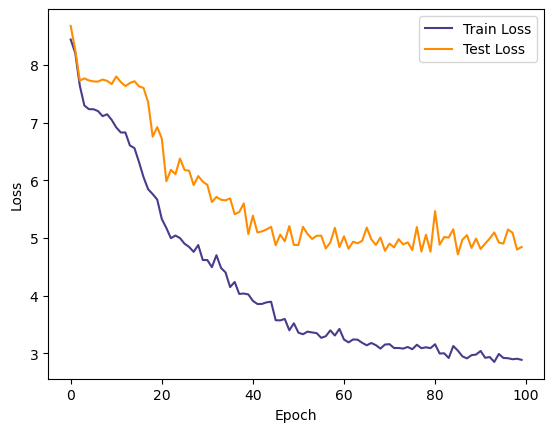

In [41]:
# Plotting

plt.plot(train_losses, label='Train Loss', color='darkslateblue')
plt.plot(test_losses, label='Test Loss', color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [48]:
import numpy as np

train_losses, test_losses = np.array(train_losses), np.array(test_losses)
np.save('outputs/model_final/train_losses.npy', train_losses)
np.save('outputs/model_final/test_losses.npy', test_losses)

In [51]:
for i, val in enumerate(train_losses):
    print(f'Epoch {i} | Train Loss: {val:.4f}')

Epoch 0 | Train Loss: 8.4400
Epoch 1 | Train Loss: 8.2066
Epoch 2 | Train Loss: 7.6400
Epoch 3 | Train Loss: 7.2962
Epoch 4 | Train Loss: 7.2326
Epoch 5 | Train Loss: 7.2322
Epoch 6 | Train Loss: 7.2003
Epoch 7 | Train Loss: 7.1121
Epoch 8 | Train Loss: 7.1446
Epoch 9 | Train Loss: 7.0469
Epoch 10 | Train Loss: 6.9169
Epoch 11 | Train Loss: 6.8288
Epoch 12 | Train Loss: 6.8292
Epoch 13 | Train Loss: 6.6038
Epoch 14 | Train Loss: 6.5582
Epoch 15 | Train Loss: 6.3162
Epoch 16 | Train Loss: 6.0526
Epoch 17 | Train Loss: 5.8464
Epoch 18 | Train Loss: 5.7608
Epoch 19 | Train Loss: 5.6660
Epoch 20 | Train Loss: 5.3301
Epoch 21 | Train Loss: 5.1746
Epoch 22 | Train Loss: 4.9982
Epoch 23 | Train Loss: 5.0437
Epoch 24 | Train Loss: 4.9994
Epoch 25 | Train Loss: 4.9019
Epoch 26 | Train Loss: 4.8461
Epoch 27 | Train Loss: 4.7607
Epoch 28 | Train Loss: 4.8794
Epoch 29 | Train Loss: 4.6199
Epoch 30 | Train Loss: 4.6190
Epoch 31 | Train Loss: 4.4956
Epoch 32 | Train Loss: 4.7031
Epoch 33 | Train Los